In [3]:
# Import packages
import pandas as pd
import numpy as np
#from w2v_utils import *
import matplotlib.pyplot as plt
%matplotlib inline
import string
import re # regular expresson package
# Import NLP packages
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# Import sklearn packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
import pickle
# Import keras for NN implementation
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [4]:
## vectorization CountVectorizer()
with open('train_data.pkl', 'rb') as f:
      X_tr, y_tr = pickle.load(f)
        
with open('test_data.pkl', 'rb') as f:
      X_te, y_te = pickle.load(f)
        
## vectorization TfidfVectorizer()
with open('train_data2.pkl', 'rb') as f:
      X_tr2, y_tr2 = pickle.load(f)
        
with open('test_data2.pkl', 'rb') as f:
      X_te2, y_te2 = pickle.load(f)

In [5]:
# Load the data for tokenizer
data = pd.read_csv('spam.csv', usecols = [0,1], encoding='latin-1')
data.columns = ['label', 'text']
print("The data has", data.shape[0], "row(s) and ", data.shape[1], "column(s)")
data.head()

The data has 5572 row(s) and  2 column(s)


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Get a word count and unique word count of the text
data.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

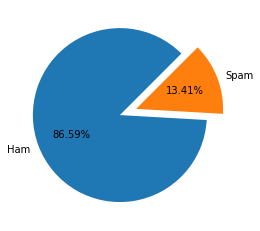

In [7]:
x = data.groupby('label').describe()
# Get the number of ham and spam
num_ham = x['text']['count'][0]
num_spam = x['text']['count'][1]
# plot a pie chart to show how many spams and hams
plt.pie([num_ham, num_spam],labels=["Ham", "Spam"],explode=(0,0.2),autopct='%1.2f%%',startangle=45)
plt.show()

In [8]:
data

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [9]:
# Encode ham and spam into binary number
le = LabelEncoder()
data.label = le.fit_transform(data.label)
data

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


We are going to try lemmatization and stopword removal. However, conventional processing techniques are not going to work well with a SMS corpus. The texts have a lot of shortened words and abbreviations. Ideally, we have to implement a customized normalization of text.

In [10]:
# Set up the english stopword library
total_stopwords = set([word.replace("'",'') for word in stopwords.words('english')]) 
# Call the lemmatizer class
lemma = WordNetLemmatizer()
def preprocess_text(text):
    text = text.lower() # Convert to lowercase
    text = text.replace("'",'') # Remove apostrophe
    text = re.sub('[^a-zA-Z]',' ',text) # using regular expression to remove 
    words = text.split() # Split the text into words by looking at the space between the texts
    # Stem the words and also remove stopwords
    words = [lemma.lemmatize(word) for word in words if (word not in total_stopwords) and (len(word)>1)] # Remove stop words
    # Put the clean words back together as a text message
    text = " ".join(words)
    return text

In [10]:
# Clean the text
data.text = data.text.apply(preprocess_text)
print(data)

,label,text
0,0,go jurong point crazy available bugis great wo...
1,0,ok lar joking wif oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,dun say early hor already say
4,0,nah dont think go usf life around though
...,...,...
5567,1,nd time tried contact pound prize claim easy c...
5568,0,going esplanade fr home
5569,0,pity mood suggestion
5570,0,guy bitching acted like id interested buying s...


In [11]:
# Split into train and test data
x_train, x_test, y_train, y_test = train_test_split(data.text, data.label, test_size=0.15, stratify=data.label)

# Word Embedding approach with RNN

In the tokenization layer, they maintain a dictionary that map a word to an index. For example, dog -> 0, cat->1, and so on.

Embedding layer will internally maintain a lookup table, and the lookup table will map the index/token to a vector, and that vector is what represent the word in the higher dimensional space. (See details for tokenizer: https://towardsdatascience.com/spam-filtering-system-with-deep-learning-b8070b28f9e0)

Summary of the process: Email -> Token -> LookUp table -> Vector

## 1. GRU with Vanila Embedding From Scratch

-The idea of Bidirectional is simple yet powerful. What it does is having two LSTM network instead of one.

-For the first LSTM network, it will feed in the input sequence as per normal. For the second LSTM network, it will reverse the input sequence and feed in to the LSTM network. The output of these two networks will be merged and then passed on to the next layer.

-The intuition behind Bidirectional is that, for some of the sentences, the context information is at the end of the sentence.

## a. GRU with data based on count-vectorized data (takes a long time to run)

In [64]:
def GRU_countVector(num_node):    
    inp = Input(shape=(9376,))
    # Embedding layer
    x = Embedding(9376, 10)(inp)
    # Bidirectional with Graded Recurrent Unit
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    # Global max layer
    x = GlobalMaxPool1D()(x)
    # 3 Hidden layers with 16 nodes
    x = Dense(num_node, activation="relu")(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dense(num_node, activation="relu")(x)
    # Dropout layer
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_tr, y_tr, batch_size=128, epochs=10, validation_data=(X_te, y_te))
    y_pred =  model.predict(X_te)
    return history, y_pred, model

In [ ]:
cv_history, cv_y_pred, cv_model = GRU_countVector()
# Save the model
cv_model.save('rnn_model/gru_cv_embedding_scratch.h5')

## b. GRU with data based on vertorized data using Tokenizer()

In [15]:
## some config values 
embed_size = 100 # how dimension of the word vector we would like to set
# Maximum number of the words within each text in the entire document 
max_len = x_train.apply(lambda str: len(str.split())).max() # max number of words

In [16]:
# Initilize the tokenzier
tok = Tokenizer()
# Fit the tokenizer to the training
tok.fit_on_texts(x_train)
# Get how many unique words to use (i.e num rows in embedding vector)
vocab_size = len(tok.word_index) + 1

In [17]:
# Convect each text message to a vector of numbers based on the order of the word
x_train_features = np.array(tok.texts_to_sequences(x_train))
x_test_features = np.array(tok.texts_to_sequences(x_test))
# ensure that all sequences in a list have the same length by padding 0 in the front for shorter sentences
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)

In [28]:
def tokenized_GRU_L1(num_node):    
    inp = Input(shape=(max_len,))
    # Embedding layer: vocab_size is the count of unique token + 1 for the 0 we added, embed size is the size of the vector space for which the words are embedded. 
    x = Embedding(vocab_size, embed_size)(inp)
    # Bidirectional with Graded Recurrent Unit with 64 units
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    # Add global max pooling layer
    x = GlobalMaxPool1D()(x)
    # Add a hidden layer
    x = Dense(num_node, activation="relu")(x)
    # Add a dropout layer
    x = Dropout(0.1)(x)
    # Output a binary class using sigmoid function
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train_features, y_train, batch_size=512, epochs=20, validation_data=(x_test_features, y_test), verbose=0)
    y_pred = model.predict(x_test_features)
    return history, y_pred, model

In [29]:
def tokenized_GRU_L3(num_node):    
    inp = Input(shape=(max_len,))
    # Embedding layer: vocab_size is the count of unique token + 1 for the 0 we added, embed size is the size of the vector space for which the words are embedded. 
    x = Embedding(vocab_size, embed_size)(inp)
    # Bidirectional with Graded Recurrent Unit with 64 units
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    # Add global max pooling layer
    x = GlobalMaxPool1D()(x)
    # Add 3 hidden layers
    x = Dense(num_node, activation="relu")(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dense(num_node, activation="relu")(x)
    # Add a dropout layer
    x = Dropout(0.1)(x)
    # Output a binary class using sigmoid function
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train_features, y_train, batch_size=512, epochs=20, validation_data=(x_test_features, y_test), verbose=0)
    y_pred = model.predict(x_test_features)
    return history, y_pred, model

In [30]:
def tokenized_GRU_L6(num_node):    
    inp = Input(shape=(max_len,))
    # Embedding layer: vocab_size is the count of unique token + 1 for the 0 we added, embed size is the size of the vector space for which the words are embedded. 
    x = Embedding(vocab_size, embed_size)(inp)
    # Bidirectional with Graded Recurrent Unit with 64 units
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    # Add global max pooling layer
    x = GlobalMaxPool1D()(x)
    # Add 6 hidden layers 
    x = Dense(num_node, activation="relu")(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dense(num_node, activation="relu")(x)
    # Add a dropout layer
    x = Dropout(0.1)(x)
    # Output a binary class using sigmoid function
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train_features, y_train, batch_size=512, epochs=20, validation_data=(x_test_features, y_test), verbose=0)
    y_pred = model.predict(x_test_features)
    return history, y_pred, model

In [26]:
def evaluate(y_test, y_pred):
    pr, rc, thresholds = precision_recall_curve(y_test, y_pred)
    # We want to get an index where precision is as close to recall rate 
    idx = np.max(np.where(pr <= rc))
    # Get the threshold where the precision and recall are as close to each other
    cutoff = thresholds[idx]
    # Print the predicted classes based on the cutoff value
    # Get the F1 scores
    print(classification_report(y_test, y_pred > cutoff))
    # Disply the confusion matrix
    confusion_test = confusion_matrix(y_test, y_pred > cutoff)
    display(pd.DataFrame(data = confusion_test, columns = ['Predicted ham', 'Predicted Spam'],index = ['Actual ham', 'Actual Spam']))


In [21]:
# Word embedding from scratch with 1 layer
# Train the models and get the history, prediction, and the models
history_tok_scratch_one_6, y_pred_tok_scratch_one_6, model_tok_scratch_one_6 = tokenized_GRU_L1(6)
history_tok_scratch_one_12, y_pred_tok_scratch_one_12, model_tok_scratch_one_12 = tokenized_GRU_L1(12)
history_tok_scratch_one_16, y_pred_tok_scratch_one_16, model_tok_scratch_one_16 = tokenized_GRU_L1(16)
history_tok_scratch_one_36, y_pred_tok_scratch_one_36, model_tok_scratch_one_36 = tokenized_GRU_L1(36)
# Get the precision, recall, and the 
pr_tok_scratch_one_6, rc_tok_scratch_one_6, thresholds_tok_scratch_one_6 = precision_recall_curve(y_test, y_pred_tok_scratch_one_6)
pr_tok_scratch_one_12, rc_tok_scratch_one_12, thresholds_tok_scratch_one_12 = precision_recall_curve(y_test, y_pred_tok_scratch_one_12)
pr_tok_scratch_one_16, rc_tok_scratch_one_16, thresholds_tok_scratch_one_16 = precision_recall_curve(y_test, y_pred_tok_scratch_one_16)
pr_tok_scratch_one_36, rc_tok_scratch_one_36, thresholds_tok_scratch_one_36 = precision_recall_curve(y_test, y_pred_tok_scratch_one_16)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4736 samples, validate on 836 samples
Epoch 1/20
4736/4736 [==============================] - 25s 5ms/step - loss: 0.6181 - accuracy: 0.8594 - val_loss: 0.5116 - val_accuracy: 0.8660
Epoch 2/20
4736/4736 [==============================] - 23s 5ms/step - loss: 0.4392 - accuracy: 0.8659 - val_loss: 0.3704 - val_accuracy: 0.8660
Epoch 3/20
4736/4736 [==============================] - 23s 5ms/step - loss: 0.3703 - accuracy: 0.8651 - val_loss: 0.3339 - val_accuracy: 0.8660
Epoch 4/20
4736/4736 [==============================] - 23s 5ms/step - loss: 0.3133 - accuracy: 0.8659 - val_loss: 0.2679 - val_accuracy: 0.8660
Epoch 5/20
4736/4736 [==============================] - 24s 5ms/step - loss: 0.2242 - accuracy: 0.8866 - val_loss: 0.1669 - val_accuracy: 0.9270
Epoch 6/20
4736/4736 [==============================] - 24s 5ms/step - loss: 0.1266 - accuracy: 0.9616 - val_loss: 0.0929 - val_accuracy: 0.9773
Epoch 7/20
4736/4736 [==============================] - 22s 5ms/step - loss: 0.0665

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4736 samples, validate on 836 samples
Epoch 1/20
4736/4736 [==============================] - 26s 6ms/step - loss: 0.6279 - accuracy: 0.8461 - val_loss: 0.5250 - val_accuracy: 0.8660
Epoch 2/20
4736/4736 [==============================] - 21s 4ms/step - loss: 0.4488 - accuracy: 0.8659 - val_loss: 0.3816 - val_accuracy: 0.8660
Epoch 3/20
4736/4736 [==============================] - 19s 4ms/step - loss: 0.3872 - accuracy: 0.8659 - val_loss: 0.3605 - val_accuracy: 0.8660
Epoch 4/20
4736/4736 [==============================] - 19s 4ms/step - loss: 0.3500 - accuracy: 0.8659 - val_loss: 0.3258 - val_accuracy: 0.8660
Epoch 5/20
4736/4736 [==============================] - 19s 4ms/step - loss: 0.2959 - accuracy: 0.8659 - val_loss: 0.2479 - val_accuracy: 0.8672
Epoch 6/20
4736/4736 [==============================] - 19s 4ms/step - loss: 0.1975 - accuracy: 0.9043 - val_loss: 0.1480 - val_accuracy: 0.9581
Epoch 7/20
4736/4736 [==============================] - 19s 4ms/step - loss: 0.1093

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4736 samples, validate on 836 samples
Epoch 1/20
4736/4736 [==============================] - 24s 5ms/step - loss: 0.6415 - accuracy: 0.8142 - val_loss: 0.5541 - val_accuracy: 0.8660
Epoch 2/20
4736/4736 [==============================] - 22s 5ms/step - loss: 0.4850 - accuracy: 0.8659 - val_loss: 0.3867 - val_accuracy: 0.8660
Epoch 3/20
4736/4736 [==============================] - 24s 5ms/step - loss: 0.3906 - accuracy: 0.8659 - val_loss: 0.3620 - val_accuracy: 0.8660
Epoch 4/20
4736/4736 [==============================] - 23s 5ms/step - loss: 0.3499 - accuracy: 0.8659 - val_loss: 0.3210 - val_accuracy: 0.8660
Epoch 5/20
4736/4736 [==============================] - 24s 5ms/step - loss: 0.2902 - accuracy: 0.8666 - val_loss: 0.2435 - val_accuracy: 0.8660
Epoch 6/20
4736/4736 [==============================] - 23s 5ms/step - loss: 0.1978 - accuracy: 0.9077 - val_loss: 0.1406 - val_accuracy: 0.9641
Epoch 7/20
4736/4736 [==============================] - 24s 5ms/step - loss: 0.1014

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4736 samples, validate on 836 samples
Epoch 1/20
4736/4736 [==============================] - 21s 4ms/step - loss: 0.6178 - accuracy: 0.8647 - val_loss: 0.5153 - val_accuracy: 0.8660
Epoch 2/20
4736/4736 [==============================] - 21s 4ms/step - loss: 0.4392 - accuracy: 0.8659 - val_loss: 0.3896 - val_accuracy: 0.8660
Epoch 3/20
4736/4736 [==============================] - 21s 4ms/step - loss: 0.3872 - accuracy: 0.8659 - val_loss: 0.3625 - val_accuracy: 0.8660
Epoch 4/20
4736/4736 [==============================] - 20s 4ms/step - loss: 0.3485 - accuracy: 0.8659 - val_loss: 0.3228 - val_accuracy: 0.8660
Epoch 5/20
4736/4736 [==============================] - 22s 5ms/step - loss: 0.2867 - accuracy: 0.8659 - val_loss: 0.2358 - val_accuracy: 0.8660
Epoch 6/20
4736/4736 [==============================] - 22s 5ms/step - loss: 0.1791 - accuracy: 0.8995 - val_loss: 0.1303 - val_accuracy: 0.9665
Epoch 7/20
4736/4736 [==============================] - 21s 5ms/step - loss: 0.0970

In [27]:
# Evluate all models with 1 layer
evaluate(y_test, y_pred_tok_scratch_one_6)
evaluate(y_test, y_pred_tok_scratch_one_12)
evaluate(y_test, y_pred_tok_scratch_one_16)
evaluate(y_test, y_pred_tok_scratch_one_36)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.96      0.96      0.96       112

    accuracy                           0.99       836
   macro avg       0.98      0.97      0.98       836
weighted avg       0.99      0.99      0.99       836



,Predicted ham,Predicted Spam
Actual ham,720,4
Actual Spam,5,107


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       724
           1       0.97      0.96      0.97       112

    accuracy                           0.99       836
   macro avg       0.98      0.98      0.98       836
weighted avg       0.99      0.99      0.99       836



,Predicted ham,Predicted Spam
Actual ham,721,3
Actual Spam,4,108


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       724
           1       0.97      0.96      0.97       112

    accuracy                           0.99       836
   macro avg       0.98      0.98      0.98       836
weighted avg       0.99      0.99      0.99       836



,Predicted ham,Predicted Spam
Actual ham,721,3
Actual Spam,4,108


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       724
           1       0.97      0.96      0.97       112

    accuracy                           0.99       836
   macro avg       0.98      0.98      0.98       836
weighted avg       0.99      0.99      0.99       836



,Predicted ham,Predicted Spam
Actual ham,721,3
Actual Spam,4,108


In [31]:
# Word embedding from scratch with 3 layer
# Train the models and get the history, prediction, and the models
history_tok_scratch_three_6, y_pred_tok_scratch_three_6, model_tok_scratch_three_6 = tokenized_GRU_L3(6)
history_tok_scratch_three_12, y_pred_tok_scratch_three_12, model_tok_scratch_three_12 = tokenized_GRU_L3(12)
history_tok_scratch_three_16, y_pred_tok_scratch_three_16, model_tok_scratch_three_16 = tokenized_GRU_L3(16)
history_tok_scratch_three_36, y_pred_tok_scratch_three_36, model_tok_scratch_three_36 = tokenized_GRU_L3(36)
# Get the precision, recall, and the 
pr_tok_scratch_three_6, rc_tok_scratch_three_6, thresholds_tok_scratch_three_6 = precision_recall_curve(y_test, y_pred_tok_scratch_three_6)
pr_tok_scratch_three_12, rc_tok_scratch_three_12, thresholds_tok_scratch_three_12 = precision_recall_curve(y_test, y_pred_tok_scratch_three_12)
pr_tok_scratch_three_16, rc_tok_scratch_three_16, thresholds_tok_scratch_three_16 = precision_recall_curve(y_test, y_pred_tok_scratch_three_16)
pr_tok_scratch_three_36, rc_tok_scratch_three_36, thresholds_tok_scratch_three_36 = precision_recall_curve(y_test, y_pred_tok_scratch_three_16)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Librar

In [32]:
# Evluate all models with 3 layer
evaluate(y_test, y_pred_tok_scratch_three_6)
evaluate(y_test, y_pred_tok_scratch_three_12)
evaluate(y_test, y_pred_tok_scratch_three_16)
evaluate(y_test, y_pred_tok_scratch_three_36)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.95      0.94      0.94       112

    accuracy                           0.98       836
   macro avg       0.97      0.96      0.97       836
weighted avg       0.98      0.98      0.98       836



,Predicted ham,Predicted Spam
Actual ham,718,6
Actual Spam,7,105


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       724
           1       0.97      0.96      0.97       112

    accuracy                           0.99       836
   macro avg       0.98      0.98      0.98       836
weighted avg       0.99      0.99      0.99       836



,Predicted ham,Predicted Spam
Actual ham,721,3
Actual Spam,4,108


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.95      0.93      0.94       112

    accuracy                           0.98       836
   macro avg       0.97      0.96      0.97       836
weighted avg       0.98      0.98      0.98       836



,Predicted ham,Predicted Spam
Actual ham,719,5
Actual Spam,8,104


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       724
           1       0.98      0.97      0.98       112

    accuracy                           0.99       836
   macro avg       0.99      0.99      0.99       836
weighted avg       0.99      0.99      0.99       836



,Predicted ham,Predicted Spam
Actual ham,722,2
Actual Spam,3,109


In [61]:
# Save the best model
model_tok_scratch_three_36.save('rnn_model/gru_tok_embedding_scratch.h5') 

In [33]:
# Word embedding from scratch with 6 layer
# Train the models and get the history, prediction, and the models
history_tok_scratch_six_6, y_pred_tok_scratch_six_6, model_tok_scratch_six_6 = tokenized_GRU_L6(6)
history_tok_scratch_six_12, y_pred_tok_scratch_six_12, model_tok_scratch_six_12 = tokenized_GRU_L6(12)
history_tok_scratch_six_16, y_pred_tok_scratch_six_16, model_tok_scratch_six_16 = tokenized_GRU_L6(16)
history_tok_scratch_six_36, y_pred_tok_scratch_six_36, model_tok_scratch_six_36 = tokenized_GRU_L6(36)
# Get the precision, recall, and the 
pr_tok_scratch_six_6, rc_tok_scratch_six_6, thresholds_tok_scratch_six_6 = precision_recall_curve(y_test, y_pred_tok_scratch_six_6)
pr_tok_scratch_six_12, rc_tok_scratch_six_12, thresholds_tok_scratch_six_12 = precision_recall_curve(y_test, y_pred_tok_scratch_six_12)
pr_tok_scratch_six_16, rc_tok_scratch_six_16, thresholds_tok_scratch_six_16 = precision_recall_curve(y_test, y_pred_tok_scratch_six_16)
pr_tok_scratch_six_36, rc_tok_scratch_six_36, thresholds_tok_scratch_six_36 = precision_recall_curve(y_test, y_pred_tok_scratch_six_16)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Librar

In [34]:
# Evluate all models with 3 layer
evaluate(y_test, y_pred_tok_scratch_six_6)
evaluate(y_test, y_pred_tok_scratch_six_12)
evaluate(y_test, y_pred_tok_scratch_six_16)
evaluate(y_test, y_pred_tok_scratch_six_36)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       724
           1       0.89      0.88      0.89       112

    accuracy                           0.97       836
   macro avg       0.94      0.93      0.94       836
weighted avg       0.97      0.97      0.97       836



,Predicted ham,Predicted Spam
Actual ham,712,12
Actual Spam,13,99


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       724
           1       0.91      0.90      0.91       112

    accuracy                           0.97       836
   macro avg       0.95      0.94      0.95       836
weighted avg       0.97      0.97      0.97       836



,Predicted ham,Predicted Spam
Actual ham,714,10
Actual Spam,11,101


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.95      0.94      0.94       112

    accuracy                           0.98       836
   macro avg       0.97      0.96      0.97       836
weighted avg       0.98      0.98      0.98       836



,Predicted ham,Predicted Spam
Actual ham,718,6
Actual Spam,7,105


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.95      0.95      0.95       112

    accuracy                           0.99       836
   macro avg       0.97      0.97      0.97       836
weighted avg       0.99      0.99      0.99       836



,Predicted ham,Predicted Spam
Actual ham,719,5
Actual Spam,6,106


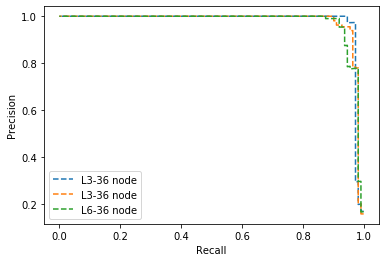

In [44]:
# Plot the precision and recall plot
plt.plot(rc_tok_scratch_one_36, pr_tok_scratch_one_36, linestyle='--', label='L3-36 node')
plt.plot(rc_tok_scratch_three_36, pr_tok_scratch_three_36, linestyle='--', label='L3-36 node')
plt.plot(rc_tok_scratch_six_36, pr_tok_scratch_six_36, linestyle='--', label='L6-36 node')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

## c. GRU with td-idf vectorized data (takes a long time to run)

In [35]:
# Explore Term Frequency Inverse Document Frequency (TF-IDF) (Source: )
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
x_train_vec = vectorizer.transform(x_train).toarray()
x_test_vec = vectorizer.transform(x_test).toarray()

In [36]:
def tdidf_GRU_three(num_node):    
    inp = Input(shape=(x_train_vec.shape[1],))
    # Embedding layer: vocab_size is the count of unique token + 1 for the 0 we added, embed size is the size of the vector space for which the words are embedded. 
    x = Embedding(x_train_vec.shape[1], 100)(inp)
    # Bidirectional with Graded Recurrent Unit
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train_vec, y_train, batch_size=128, epochs=10, validation_data=(x_test_vec, y_test), verbose=0)
    y_pred = model.predict(x_test_vec)
    return history, y_pred, model

In [ ]:
# Since three layers with 36 nodes perform the best, we will use this architecture to train on td-idf vectorized data
hist_tdidf, y_pred_tdidf, model_tdidf_scratch_three_36 = tdidf_GRU_three(36)
model_tdidf_scratch_three_36.save('rnn_model/gru_tdidf_embedding_scratch.h5') 

## 2. GRU with GloVe pre-trained embedding layer

In [37]:
# Empty dictionary
embeddings_index = dict()
f = open('glove.6B.300d.txt')
# Write pretrained word embedding layer to a dictoray
for line in f:
    # split up word and the vector
    values = line.split()
    # Get an index for that word
    word = values[0]
    # Put the word vectors as a numpy array
    coefs = np.asarray(values[1:], dtype='float32')
    # Put each word vector to map to its index for that word
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [38]:
# create a weight matrix for words in training docs
# We can set our parameter instead of 300, vocab_size is how many tokens we have assigned, or the number of words
embedding_matrix = np.zeros((vocab_size, 300))
# Loop through the words and index and create a embedding matrix using each word vector
for word, i in tok.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [46]:
def pretrainedGRU_L1(num_node):
    inp = Input(shape=(max_len,))
    # Embedding layer: vocab_size is the count of unique token + 1 for the 0 we added, embed size is the size of the vector space for which the words are embedded. 
    x = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(inp)
    # Bidirectional with Graded Recurrent Unit
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train_features, y_train, batch_size=512, epochs=20, validation_data=(x_test_features, y_test), verbose=0)
    y_pred = model.predict(x_test_features)
    return history, y_pred, model

In [47]:
def pretrainedGRU_L3(num_node):
    inp = Input(shape=(max_len,))
    # Embedding layer: vocab_size is the count of unique token + 1 for the 0 we added, embed size is the size of the vector space for which the words are embedded. 
    x = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(inp)
    # Bidirectional with Graded Recurrent Unit
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train_features, y_train, batch_size=512, epochs=20, validation_data=(x_test_features, y_test), verbose =0)
    y_pred = model.predict(x_test_features)
    return history,y_pred, model

In [48]:
def pretrainedGRU_L6(num_node):
    inp = Input(shape=(max_len,))
    # Embedding layer: vocab_size is the count of unique token + 1 for the 0 we added, embed size is the size of the vector space for which the words are embedded. 
    x = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(inp)
    # Bidirectional with Graded Recurrent Unit
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dense(num_node, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train_features, y_train, batch_size=512, epochs=20, validation_data=(x_test_features, y_test))
    y_pred = model.predict(x_test_features)
    return history,y_pred, model

In [54]:
history_tok_pretrained_one_6, y_pred_tok_pretrained_one_6, model_tok_pretrained_one_6 = pretrainedGRU_L1(6)
history_tok_pretrained_one_12, y_pred_tok_pretrained_one_12, model_tok_pretrained_one_12 = pretrainedGRU_L1(12)
history_tok_pretrained_one_16, y_pred_tok_pretrained_one_16, model_tok_pretrained_one_16 = pretrainedGRU_L1(16)
history_tok_pretrained_one_36, y_pred_tok_pretrained_one_36, model_tok_pretrained_one_36 = pretrainedGRU_L1(36)

In [55]:
# Get the precision, recall, and the 
pr_tok_pretrained_one_6, rc_tok_pretrained_one_6, thresholds_tok_pretrained_one_6 = precision_recall_curve(y_test, y_pred_tok_pretrained_one_6)
pr_tok_pretrained_one_12, rc_tok_pretrained_one_12, thresholds_tok_pretrained_one_12 = precision_recall_curve(y_test, y_pred_tok_pretrained_one_12)
pr_tok_pretrained_one_16, rc_tok_pretrained_one_16, thresholds_tok_pretrained_one_16 = precision_recall_curve(y_test, y_pred_tok_pretrained_one_16)
pr_tok_pretrained_one_36, rc_tok_pretrained_one_36, thresholds_tok_pretrained_one_36 = precision_recall_curve(y_test, y_pred_tok_pretrained_one_36)


In [56]:
# Evaluate all the pretrained models with 1 layers 
evaluate(y_test, y_pred_tok_pretrained_one_6)
evaluate(y_test, y_pred_tok_pretrained_one_12)
evaluate(y_test, y_pred_tok_pretrained_one_16)
evaluate(y_test, y_pred_tok_pretrained_one_36)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.96      0.96      0.96       112

    accuracy                           0.99       836
   macro avg       0.98      0.97      0.98       836
weighted avg       0.99      0.99      0.99       836



,Predicted ham,Predicted Spam
Actual ham,720,4
Actual Spam,5,107


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.95      0.95      0.95       112

    accuracy                           0.99       836
   macro avg       0.97      0.97      0.97       836
weighted avg       0.99      0.99      0.99       836



,Predicted ham,Predicted Spam
Actual ham,719,5
Actual Spam,6,106


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.95      0.95      0.95       112

    accuracy                           0.99       836
   macro avg       0.97      0.97      0.97       836
weighted avg       0.99      0.99      0.99       836



,Predicted ham,Predicted Spam
Actual ham,719,5
Actual Spam,6,106


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.96      0.96      0.96       112

    accuracy                           0.99       836
   macro avg       0.98      0.97      0.98       836
weighted avg       0.99      0.99      0.99       836



,Predicted ham,Predicted Spam
Actual ham,720,4
Actual Spam,5,107


In [49]:
history_tok_pretrained_three_6, y_pred_tok_pretrained_three_6, model_tok_pretrained_three_6 = pretrainedGRU_L3(6)
history_tok_pretrained_three_12, y_pred_tok_pretrained_three_12, model_tok_pretrained_three_12 = pretrainedGRU_L3(12)
history_tok_pretrained_three_16, y_pred_tok_pretrained_three_16, model_tok_pretrained_three_16 = pretrainedGRU_L3(16)
history_tok_pretrained_three_36, y_pred_tok_pretrained_three_36, model_tok_pretrained_three_36 = pretrainedGRU_L3(36)


In [53]:
# Get the precision, recall, and the 
pr_tok_pretrained_three_6, rc_tok_pretrained_three_6, thresholds_tok_pretrained_three_6 = precision_recall_curve(y_test, y_pred_tok_pretrained_three_6)
pr_tok_pretrained_three_12, rc_tok_pretrained_three_12, thresholds_tok_pretrained_three_12 = precision_recall_curve(y_test, y_pred_tok_pretrained_three_12)
pr_tok_pretrained_three_16, rc_tok_pretrained_three_16, thresholds_tok_pretrained_three_16 = precision_recall_curve(y_test, y_pred_tok_pretrained_three_16)
pr_tok_pretrained_three_36, rc_tok_pretrained_three_36, thresholds_tok_pretrained_three_36 = precision_recall_curve(y_test, y_pred_tok_pretrained_three_36)


In [50]:
# Evaluate all the pretrained models with 3 layers 
evaluate(y_test, y_pred_tok_pretrained_three_6)
evaluate(y_test, y_pred_tok_pretrained_three_12)
evaluate(y_test, y_pred_tok_pretrained_three_16)
evaluate(y_test, y_pred_tok_pretrained_three_36)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.95      0.94      0.94       112

    accuracy                           0.98       836
   macro avg       0.97      0.96      0.97       836
weighted avg       0.98      0.98      0.98       836



,Predicted ham,Predicted Spam
Actual ham,718,6
Actual Spam,7,105


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.95      0.95      0.95       112

    accuracy                           0.99       836
   macro avg       0.97      0.97      0.97       836
weighted avg       0.99      0.99      0.99       836



,Predicted ham,Predicted Spam
Actual ham,719,5
Actual Spam,6,106


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.96      0.96      0.96       112

    accuracy                           0.99       836
   macro avg       0.98      0.97      0.98       836
weighted avg       0.99      0.99      0.99       836



,Predicted ham,Predicted Spam
Actual ham,720,4
Actual Spam,5,107


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.95      0.95      0.95       112

    accuracy                           0.99       836
   macro avg       0.97      0.97      0.97       836
weighted avg       0.99      0.99      0.99       836



,Predicted ham,Predicted Spam
Actual ham,719,5
Actual Spam,6,106


In [42]:
history_tok_pretrained_six_6, y_pred_tok_pretrained_six_6, model_tok_pretrained_six_6 = pretrainedGRU_L6(6)
history_tok_pretrained_six_12, y_pred_tok_pretrained_six_12, model_tok_pretrained_six_12 = pretrainedGRU_L6(12)
history_tok_pretrained_six_16, y_pred_tok_pretrained_six_16, model_tok_pretrained_six_16 = pretrainedGRU_L6(16)
history_tok_pretrained_six_36, y_pred_tok_pretrained_six_36, model_tok_pretrained_six_36 = pretrainedGRU_L6(36)

Train on 4736 samples, validate on 836 samples
Epoch 1/20
4736/4736 [==============================] - 26s 6ms/step - loss: 0.6879 - accuracy: 0.7456 - val_loss: 0.6759 - val_accuracy: 0.8660
Epoch 2/20
4736/4736 [==============================] - 22s 5ms/step - loss: 0.6667 - accuracy: 0.8697 - val_loss: 0.6531 - val_accuracy: 0.8660
Epoch 3/20
4736/4736 [==============================] - 22s 5ms/step - loss: 0.6433 - accuracy: 0.8792 - val_loss: 0.6275 - val_accuracy: 0.9055
Epoch 4/20
4736/4736 [==============================] - 22s 5ms/step - loss: 0.6166 - accuracy: 0.9377 - val_loss: 0.5991 - val_accuracy: 0.9617
Epoch 5/20
4736/4736 [==============================] - 22s 5ms/step - loss: 0.5864 - accuracy: 0.9649 - val_loss: 0.5683 - val_accuracy: 0.9749
Epoch 6/20
4736/4736 [==============================] - 22s 5ms/step - loss: 0.5538 - accuracy: 0.9683 - val_loss: 0.5328 - val_accuracy: 0.9880
Epoch 7/20
4736/4736 [==============================] - 23s 5ms/step - loss: 0.5152

4736/4736 [==============================] - 25s 5ms/step - loss: 0.0961 - accuracy: 0.9964 - val_loss: 0.1200 - val_accuracy: 0.9880
Epoch 17/20
4736/4736 [==============================] - 24s 5ms/step - loss: 0.0922 - accuracy: 0.9968 - val_loss: 0.1147 - val_accuracy: 0.9880
Epoch 18/20
4736/4736 [==============================] - 24s 5ms/step - loss: 0.0894 - accuracy: 0.9973 - val_loss: 0.1107 - val_accuracy: 0.9856
Epoch 19/20
4736/4736 [==============================] - 25s 5ms/step - loss: 0.0874 - accuracy: 0.9977 - val_loss: 0.1302 - val_accuracy: 0.9868
Epoch 20/20
4736/4736 [==============================] - 24s 5ms/step - loss: 0.0797 - accuracy: 0.9981 - val_loss: 0.1010 - val_accuracy: 0.9892
Train on 4736 samples, validate on 836 samples
Epoch 1/20
4736/4736 [==============================] - 32s 7ms/step - loss: 0.6698 - accuracy: 0.6936 - val_loss: 0.5718 - val_accuracy: 0.8660
Epoch 2/20
4736/4736 [==============================] - 28s 6ms/step - loss: 0.4728 - accu

In [51]:
# Get the precision, recall, and the 
pr_tok_pretrained_six_6, rc_tok_pretrained_six_6, thresholds_tok_pretrained_six_6 = precision_recall_curve(y_test, y_pred_tok_pretrained_six_6)
pr_tok_pretrained_six_12, rc_tok_pretrained_six_12, thresholds_tok_pretrained_six_12 = precision_recall_curve(y_test, y_pred_tok_pretrained_six_12)
pr_tok_pretrained_six_16, rc_tok_pretrained_six_16, thresholds_tok_pretrained_six_16 = precision_recall_curve(y_test, y_pred_tok_pretrained_six_16)
pr_tok_pretrained_six_36, rc_tok_pretrained_six_36, thresholds_tok_pretrained_six_36 = precision_recall_curve(y_test, y_pred_tok_pretrained_six_36)


In [52]:
# Evaluate all the pretrained models with 6 layers 
evaluate(y_test, y_pred_tok_pretrained_six_6)
evaluate(y_test, y_pred_tok_pretrained_six_12)
evaluate(y_test, y_pred_tok_pretrained_six_16)
evaluate(y_test, y_pred_tok_pretrained_six_36)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.95      0.95      0.95       112

    accuracy                           0.99       836
   macro avg       0.97      0.97      0.97       836
weighted avg       0.99      0.99      0.99       836



,Predicted ham,Predicted Spam
Actual ham,719,5
Actual Spam,6,106


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.95      0.94      0.94       112

    accuracy                           0.98       836
   macro avg       0.97      0.96      0.97       836
weighted avg       0.98      0.98      0.98       836



,Predicted ham,Predicted Spam
Actual ham,718,6
Actual Spam,7,105


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.95      0.95      0.95       112

    accuracy                           0.99       836
   macro avg       0.97      0.97      0.97       836
weighted avg       0.99      0.99      0.99       836



,Predicted ham,Predicted Spam
Actual ham,719,5
Actual Spam,6,106


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.96      0.96      0.96       112

    accuracy                           0.99       836
   macro avg       0.98      0.97      0.98       836
weighted avg       0.99      0.99      0.99       836



,Predicted ham,Predicted Spam
Actual ham,720,4
Actual Spam,5,107


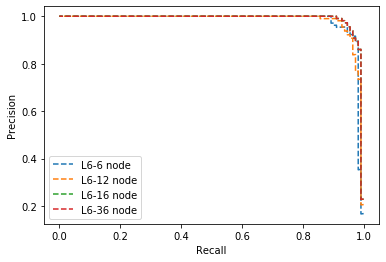

In [45]:
# Plot the precision and recall plot
plt.plot(rc_tok_pretrained_six_6, pr_tok_pretrained_six_6, linestyle='--', label='L6-6 node')
plt.plot(rc_tok_pretrained_six_12, pr_tok_pretrained_six_12, linestyle='--', label='L6-12 node')
plt.plot(rc_tok_pretrained_six_16, pr_tok_pretrained_six_16, linestyle='--', label='L6-16 node')
plt.plot(rc_tok_pretrained_six_36, pr_tok_pretrained_six_36, linestyle='--', label='L6-36 node')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()